# Estimate car vs bus travel time

* Pull out parallel routes. Run `setup_parallel_trips_with_stops.py`
* Make car travel down same route as the bus. Use `googlemaps`, and set the departure hour to be the same time as bus route's.
    * `osmx` snaps to nodes, but even for every 5th bus stop, it's snapping to same node.
    * `osrm` wasn't able to be installed in Hub

In [ ]:
#!pip install -r requirements.txt

In [1]:
#https://stackoverflow.com/questions/55162077/how-to-get-the-driving-distance-between-two-geographical-coordinates-using-pytho
import dotenv
import geopandas as gpd
import googlemaps
import intake
import os
import pandas as pd

from datetime import datetime, timedelta
from siuba import *

dotenv.load_dotenv("_env")

catalog = intake.open_catalog("./*.yml")

GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def grab_latlon_make_tuple(df, point_geom_col):
    # Change this from shapely point to floats
    df = df.assign(
        longitude = df[point_geom_col].x,
        latitude = df[point_geom_col].y,
    )
    
    # Make tuples instead of just floats
    df2 = (df.assign(
            new = df.apply(lambda x: (x.latitude, x.longitude), axis=1)        
        ).rename(columns = {"new": f"{point_geom_col}_tuple"})
          .drop(columns = ["latitude", "longitude"])
    )
    
    return df2

In [3]:
def data_wrangling(df):
    # Move this step into script later? 
    # Or just leave in this notebook, wrangle it into what goes into googlemaps
    df = df.assign(
        # Just grab time because googlemaps doesn't want past date 
        departure_time = pd.to_datetime(df.departure_time, errors="coerce").dt.time,
    )
    
    df2 = (grab_latlon_make_tuple(df, "geometry")
           .drop(columns = "geometry")
           .rename(columns = {"geometry_tuple": "geometry"})
          )
    
    return df2

In [4]:
df = catalog.parallel_trips_with_stops.read()

df = data_wrangling(df)

# Selecting 2 trips
keep_trips = [
    -7505741281882708052,
    -8806955513757008482 
]

df = df[df.trip_key.isin(keep_trips)].reset_index(drop=True)

In [128]:
full_df["stop_rank"] = full_df.groupby(trip_group).cumcount() + 1

In [130]:
# every 3rd for shorter routes
# every 4th, 5th for longer ones...stay under 25 waypoints
full_df.stop_rank.max()/2

89.0

In [ ]:
# if there are any keys that don't have duration_in_traffic, throw an error and it's not getting what we expect


In [131]:
# if it feels too slow, parallelize this in some way
# async io it!
# functools cache?
# write a function, take beginning, end, waypoints, departure time, and have that
# function reference the map's call

In [5]:
trip_group = ["calitp_itp_id", "route_id", "trip_id", "shape_id"]

def subset_stops(df, n):
    # https://stackoverflow.com/questions/25055712/pandas-every-nth-row
    # Maybe not use every bus stop, since bus stops are spaced fairly closely
    # Maybe every other, every 3rd? want to mimic the bus route, do not want
    # to stray too far

    # df = df.iloc[::3]
    df["stop_rank"] = df.groupby(trip_group).cumcount() + 1
    
    subset = df[df.stop_rank % n == 0]
    
    return subset

In [6]:
# For now, take every 3rd stop, stop 3, 6, 9..
# Then, append 1st and last stops on to be origin/destination.
# Potentially increase this to every 5th?
subset = subset_stops(df, 3)

In [7]:
def select_origin_destination(df):
    df = df.assign(
        origin = (df.sort_values(trip_group + ["stop_sequence"])
                  .groupby(trip_group)["stop_sequence"]
                  .transform("min")
                 ),
        destination = (df.sort_values(trip_group + ["stop_sequence"])
                       .groupby(trip_group)["stop_sequence"]
                       .transform("max")
                      )
    )
    
    df2 = (df[(df.stop_sequence == df.origin) | 
             (df.stop_sequence == df.destination)]
           .reset_index(drop=True)
          )
    
    
    # Wrangle it so there are columns with previous point and current point in the same row
    df2 = df2.assign(
        previous = (df2.sort_values(trip_group + ["stop_sequence"])
                        .groupby(trip_group)["geometry"]
                        .apply(lambda x: x.shift(1))
                       ),
    )
    
    # Only keep the observation that has start_geom (drop the first obs for each trip grouping)
    df3 = (df2[df2.previous.notna()]
           [trip_group + ["departure_time", "geometry", "previous"]]
           .reset_index(drop=True)
           .rename(columns = {"geometry": "destination", 
                              "previous": "origin"})
          )
    
    return df3

In [8]:
od = select_origin_destination(df)
od

,calitp_itp_id,route_id,trip_id,shape_id,departure_time,destination,origin
0,4,10,13277020,shp-10-10,07:08:00,"(37.670239, -122.08718)","(37.721266, -122.160201)"
1,182,910-13153,10910002100513-DEC21,9100210_DEC21,06:02:00,"(33.869338, -118.287306)","(34.072191, -118.045132)"


In [9]:
# Try googlemaps.directions(), which allows for waypoints put in as an array
def assemble_waypoints(df):
    # Take all the stops in between origin/destination, put tuples into a list
    #https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby
    waypoint_df = (
        df.sort_values(trip_group + ["stop_sequence"])
        .groupby(trip_group)
        .agg({"geometry": lambda x: list(x)})
        .reset_index()
        .rename(columns = {"geometry": "waypoints"})
    )
    
    return waypoint_df

In [10]:
waypoints_by_trip = assemble_waypoints(subset)
waypoints_by_trip

,calitp_itp_id,route_id,trip_id,shape_id,waypoints
0,4,10,13277020,shp-10-10,"[(37.724727, -122.157549), (37.722488, -122.15..."
1,182,910-13153,10910002100513-DEC21,9100210_DEC21,"[(34.055644, -118.21099), (34.054253, -118.243..."


In [11]:
final = pd.merge(od, waypoints_by_trip, 
                 on = trip_group, how = "inner", validate = "1:1"
                )

final.head()

,calitp_itp_id,route_id,trip_id,shape_id,departure_time,destination,origin,waypoints
0,4,10,13277020,shp-10-10,07:08:00,"(37.670239, -122.08718)","(37.721266, -122.160201)","[(37.724727, -122.157549), (37.722488, -122.15..."
1,182,910-13153,10910002100513-DEC21,9100210_DEC21,06:02:00,"(33.869338, -118.287306)","(34.072191, -118.045132)","[(34.055644, -118.21099), (34.054253, -118.243..."


In [ ]:
#https://www.geeksforgeeks.org/python-calculate-distance-duration-two-places-using-google-distance-matrix-api/

In [12]:
gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

In [13]:
one_hr_from_now = (datetime.now() + timedelta(hours=1)).time()

In [ ]:
# maxsize=None, cache 

In [14]:
origin = final.origin.tolist()
dest = final.destination.tolist()
#departures = final.departure_time.tolist()
departures = [one_hr_from_now]
waypts = final.waypoints.tolist()

print(f"type of origin input: {type(origin)}")
print(f"type of first row: {type(origin[0])}")

for i, tup in enumerate(zip(origin, dest)):
    if i == 0:
        print(i, tup)
        print(tup[0])
        print(departures[i])
        print(waypts[i])
        print(type(waypts[i]))

type of origin input: <class 'list'>
type of first row: <class 'tuple'>
0 ((37.721266, -122.160201), (37.670239, -122.08718))
(37.721266, -122.160201)
17:27:19.803644
[(37.724727, -122.157549), (37.722488, -122.152545), (37.717496, -122.145962), (37.71253, -122.139188), (37.705447, -122.12906), (37.699342, -122.121197), (37.698266, -122.124512), (37.695795, -122.11529), (37.690661, -122.107995), (37.683028, -122.097653), (37.67769, -122.090881), (37.670239, -122.08718)]
<class 'list'>


In [15]:
# Just do 1 query
beginning = (37.721266, -122.160201)
ending = (37.670239, -122.08718)
departure1 = departures[0]
waypts1 = waypts[0]

In [ ]:
# save as dictionary, save as pickle. request/response, save as pickle to be "cache"

In [30]:
gmaps.directions(beginning, ending, 
                 mode='driving', 
                 #departure_time=departure1, 
                 #waypoints=waypts1
                )

[{'bounds': {'northeast': {'lat': 37.7211383, 'lng': -122.0873249},
   'southwest': {'lat': 37.6662295, 'lng': -122.1682915}},
  'copyrights': 'Map data ©2022',
  'legs': [{'distance': {'text': '7.3 mi', 'value': 11705},
    'duration': {'text': '15 mins', 'value': 928},
    'end_address': 'Hayward BART, Hayward, CA 94541, USA',
    'end_location': {'lat': 37.6702603, 'lng': -122.0873249},
    'start_address': 'San Leandro BART, San Leandro, CA 94577, USA',
    'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
    'steps': [{'distance': {'text': '489 ft', 'value': 149},
      'duration': {'text': '1 min', 'value': 37},
      'end_location': {'lat': 37.71998800000001, 'lng': -122.1596647},
      'html_instructions': 'Head <b>southeast</b> toward <b>Parrott St</b>',
      'polyline': {'points': 'clfeFfnrhVNI~@q@NKj@a@|@o@ZQ'},
      'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
      'travel_mode': 'DRIVING'},
     {'distance': {'text': '203 ft', 'value': 62},
   

In [31]:
test_result = gmaps.directions(beginning, ending, 
                 mode='driving', 
                 #departure_time=departure1, 
                 #waypoints=waypts1
                )

In [38]:
my_dict = test_result[0]

In [40]:
for key in my_dict.keys():
    print(key)

bounds
copyrights
legs
overview_polyline
summary
warnings
waypoint_order


In [46]:
my_dict["summary"]

'I-880 S'

In [42]:
my_dict["legs"]

[{'distance': {'text': '7.3 mi', 'value': 11705},
  'duration': {'text': '15 mins', 'value': 928},
  'end_address': 'Hayward BART, Hayward, CA 94541, USA',
  'end_location': {'lat': 37.6702603, 'lng': -122.0873249},
  'start_address': 'San Leandro BART, San Leandro, CA 94577, USA',
  'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
  'steps': [{'distance': {'text': '489 ft', 'value': 149},
    'duration': {'text': '1 min', 'value': 37},
    'end_location': {'lat': 37.71998800000001, 'lng': -122.1596647},
    'html_instructions': 'Head <b>southeast</b> toward <b>Parrott St</b>',
    'polyline': {'points': 'clfeFfnrhVNI~@q@NKj@a@|@o@ZQ'},
    'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
    'travel_mode': 'DRIVING'},
   {'distance': {'text': '203 ft', 'value': 62},
    'duration': {'text': '1 min', 'value': 19},
    'end_location': {'lat': 37.7202455, 'lng': -122.1590436},
    'html_instructions': 'Turn <b>left</b> onto <b>Parrott St</b>',
    'maneuver': 'turn-

In [54]:
journey = my_dict["legs"][0]

In [59]:
for key, value in journey.items():
    print(key)
    print(value)

distance
{'text': '7.3 mi', 'value': 11705}
duration
{'text': '15 mins', 'value': 928}
end_address
Hayward BART, Hayward, CA 94541, USA
end_location
{'lat': 37.6702603, 'lng': -122.0873249}
start_address
San Leandro BART, San Leandro, CA 94577, USA
start_location
{'lat': 37.7211383, 'lng': -122.1605215}
steps
[{'distance': {'text': '489 ft', 'value': 149}, 'duration': {'text': '1 min', 'value': 37}, 'end_location': {'lat': 37.71998800000001, 'lng': -122.1596647}, 'html_instructions': 'Head <b>southeast</b> toward <b>Parrott St</b>', 'polyline': {'points': 'clfeFfnrhVNI~@q@NKj@a@|@o@ZQ'}, 'start_location': {'lat': 37.7211383, 'lng': -122.1605215}, 'travel_mode': 'DRIVING'}, {'distance': {'text': '203 ft', 'value': 62}, 'duration': {'text': '1 min', 'value': 19}, 'end_location': {'lat': 37.7202455, 'lng': -122.1590436}, 'html_instructions': 'Turn <b>left</b> onto <b>Parrott St</b>', 'maneuver': 'turn-left', 'polyline': {'points': '}dfeFzhrhVQi@a@qA'}, 'start_location': {'lat': 37.7199880

In [67]:
# add 7 days in the future
# test a week, 6 weeks from now, google maps probs does day of week/time of day, not seasonal
# timedelta as number of weeks (integer), add 1, adjust that forward
# <25 waypoints, <10 waypoints, or else pay extra, 
# if you have more than 25, you have to break it into 2 requests

datetime.time(17, 27, 19, 803644)

In [16]:
gmaps.directions(beginning, ending, 
                 mode='driving', 
                 departure_time=departure1, 
                 #waypoints=waypts1
                )

HTTPError: HTTP Error: 400

In [112]:
via = gmaps.directions(beginning, ending, 
                 mode='driving', 
                 departure_time=datetime.now() + timedelta(hours=4), 
                 waypoints=[f"via:{lat},{lon}" for lat, lon in waypts1]
                #waypoints=waypts1
                )
waypoints = gmaps.directions(beginning, ending, 
                 mode='driving', 
                 departure_time=datetime.now() + timedelta(hours=4), 
                 #waypoints=[f"via:{lat},{lon}" for lat, lon in waypts1]
                waypoints=waypts1
                )
# Try using via, not using stopovers, which will return duration_in_traffic


In [113]:
via[0].keys(), waypoints[0].keys()

(dict_keys(['bounds', 'copyrights', 'legs', 'overview_polyline', 'summary', 'warnings', 'waypoint_order']),
 dict_keys(['bounds', 'copyrights', 'legs', 'overview_polyline', 'summary', 'warnings', 'waypoint_order']))

In [114]:
via[0]["legs"][0]["duration_in_traffic"], via[0]["legs"][0]["duration"],sum(leg["duration"]["value"] for leg in waypoints[0]["legs"])



({'text': '30 mins', 'value': 1794}, {'text': '28 mins', 'value': 1673}, 1671)

In [104]:
waypoints[0]["legs"][0]

{'distance': {'text': '0.6 mi', 'value': 929},
 'duration': {'text': '3 mins', 'value': 177},
 'end_address': 'Hays St & W Estudillo Av, San Leandro, CA 94577, USA',
 'end_location': {'lat': 37.7246916, 'lng': -122.1576365},
 'start_address': 'San Leandro BART, San Leandro, CA 94577, USA',
 'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
 'steps': [{'distance': {'text': '489 ft', 'value': 149},
   'duration': {'text': '1 min', 'value': 37},
   'end_location': {'lat': 37.71998800000001, 'lng': -122.1596647},
   'html_instructions': 'Head <b>southeast</b> toward <b>Parrott St</b>',
   'polyline': {'points': 'clfeFfnrhVNI~@q@NKj@a@|@o@ZQ'},
   'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
   'travel_mode': 'DRIVING'},
  {'distance': {'text': '0.2 mi', 'value': 399},
   'duration': {'text': '1 min', 'value': 73},
   'end_location': {'lat': 37.7216452, 'lng': -122.1556473},
   'html_instructions': 'Turn <b>left</b> onto <b>Parrott St</b>',
   'maneuver': 'turn-left

In [102]:
set(type(leg["duration"]) for leg in waypoints[0]["legs"])


{dict}

In [96]:
sum(leg["duration"] for leg in waypoints[0]["legs"])


TypeError: string indices must be integers

In [92]:
via[0]["legs"][0].keys(), waypoints[0]["legs"][0].keys()

(dict_keys(['distance', 'duration', 'duration_in_traffic', 'end_address', 'end_location', 'start_address', 'start_location', 'steps', 'traffic_speed_entry', 'via_waypoint']),
 dict_keys(['distance', 'duration', 'end_address', 'end_location', 'start_address', 'start_location', 'steps', 'traffic_speed_entry', 'via_waypoint']))

In [86]:
via2[0]["legs"][0]

{'distance': {'text': '0.6 mi', 'value': 929},
 'duration': {'text': '3 mins', 'value': 177},
 'end_address': 'Hays St & W Estudillo Av, San Leandro, CA 94577, USA',
 'end_location': {'lat': 37.7246916, 'lng': -122.1576365},
 'start_address': 'San Leandro BART, San Leandro, CA 94577, USA',
 'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
 'steps': [{'distance': {'text': '489 ft', 'value': 149},
   'duration': {'text': '1 min', 'value': 37},
   'end_location': {'lat': 37.71998800000001, 'lng': -122.1596647},
   'html_instructions': 'Head <b>southeast</b> toward <b>Parrott St</b>',
   'polyline': {'points': 'clfeFfnrhVNI~@q@NKj@a@|@o@ZQ'},
   'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
   'travel_mode': 'DRIVING'},
  {'distance': {'text': '0.2 mi', 'value': 399},
   'duration': {'text': '1 min', 'value': 73},
   'end_location': {'lat': 37.7216452, 'lng': -122.1556473},
   'html_instructions': 'Turn <b>left</b> onto <b>Parrott St</b>',
   'maneuver': 'turn-left

In [60]:
departure1

datetime.time(17, 27, 19, 803644)

In [61]:
tomorrow = datetime.now() + timedelta(days=1)

In [ ]:
with_waypoints = gmaps.directions(beginning, ending, 
                 mode='driving', 
                 departure_time=departure1, 
                 waypoints=waypts1
                )

In [18]:
with_waypoints = gmaps.directions(beginning, ending, 
                 mode='driving', 
                 departure_time=tomorrow, 
                 #waypoints=waypts1
                )

In [66]:
gmaps.directions(beginning, ending, 
                 mode='driving', 
                 departure_time=datetime.now() + timedelta(hours=-1), 
                 #waypoints=waypts1
                )

ApiError: INVALID_REQUEST (departure_time is in the past. Traffic information is only available for future and current times.)

In [19]:
w1 = with_waypoints[0]

In [24]:
#https://stackoverflow.com/questions/15380712/how-to-decode-polylines-from-google-maps-direction-api-in-php
def decode_polyline(polyline_str):
    index, lat, lng = 0, 0, 0
    coordinates = []
    changes = {'latitude': 0, 'longitude': 0}

    # Coordinates have variable length when encoded, so just keep
    # track of whether we've hit the end of the string. In each
    # while loop iteration, a single coordinate is decoded.
    while index < len(polyline_str):
        # Gather lat/lon changes, store them in a dictionary to apply them later
        for unit in ['latitude', 'longitude']: 
            shift, result = 0, 0

            while True:
                byte = ord(polyline_str[index]) - 63
                index+=1
                result |= (byte & 0x1f) << shift
                shift += 5
                if not byte >= 0x20:
                    break

            if (result & 1):
                changes[unit] = ~(result >> 1)
            else:
                changes[unit] = (result >> 1)

        lat += changes['latitude']
        lng += changes['longitude']

        coordinates.append((lat / 100000.0, lng / 100000.0))

    return coordinates

In [36]:
w1

{'bounds': {'northeast': {'lat': 37.7257391, 'lng': -122.0873034},
  'southwest': {'lat': 37.670141, 'lng': -122.1605215}},
 'copyrights': 'Map data ©2022',
 'legs': [{'distance': {'text': '0.6 mi', 'value': 929},
   'duration': {'text': '3 mins', 'value': 177},
   'end_address': 'Hays St & W Estudillo Av, San Leandro, CA 94577, USA',
   'end_location': {'lat': 37.7246916, 'lng': -122.1576365},
   'start_address': 'San Leandro BART, San Leandro, CA 94577, USA',
   'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
   'steps': [{'distance': {'text': '489 ft', 'value': 149},
     'duration': {'text': '1 min', 'value': 37},
     'end_location': {'lat': 37.71998800000001, 'lng': -122.1596647},
     'html_instructions': 'Head <b>southeast</b> toward <b>Parrott St</b>',
     'polyline': {'points': 'clfeFfnrhVNI~@q@NKj@a@|@o@ZQ'},
     'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
     'travel_mode': 'DRIVING'},
    {'distance': {'text': '0.2 mi', 'value': 399},
     'd

In [30]:
step_by_step = w1['legs'][0]['steps']

In [32]:
step_by_step

[{'distance': {'text': '489 ft', 'value': 149},
  'duration': {'text': '1 min', 'value': 37},
  'end_location': {'lat': 37.71998800000001, 'lng': -122.1596647},
  'html_instructions': 'Head <b>southeast</b> toward <b>Parrott St</b>',
  'polyline': {'points': 'clfeFfnrhVNI~@q@NKj@a@|@o@ZQ'},
  'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
  'travel_mode': 'DRIVING'},
 {'distance': {'text': '0.2 mi', 'value': 399},
  'duration': {'text': '1 min', 'value': 73},
  'end_location': {'lat': 37.7216452, 'lng': -122.1556473},
  'html_instructions': 'Turn <b>left</b> onto <b>Parrott St</b>',
  'maneuver': 'turn-left',
  'polyline': {'points': '}dfeFzhrhVQi@a@qAG[Qi@eAgD{A}EsAgEGQ'},
  'start_location': {'lat': 37.71998800000001, 'lng': -122.1596647},
  'travel_mode': 'DRIVING'},
 {'distance': {'text': '0.2 mi', 'value': 381},
  'duration': {'text': '1 min', 'value': 67},
  'end_location': {'lat': 37.7246916, 'lng': -122.1576365},
  'html_instructions': 'Turn <b>left</b> onto <b>Hay

In [33]:
polyline = w1["overview_polyline"]

In [37]:
polyline

{'points': 'clfeFfnrhVjCiB|@o@ZQQi@i@mBwAqEoDeLGQ_@RqEhCyCbBkDpByC`B}@}Ca@qAj@q@dBkCl@{@v@iAdBqC~CuE~BuDjFyHlDcFdG{IlFaIjCyDfEgGtFsINCRWhAgBdBmC|AcCBKHY`AuATMr@eA|BoDvBkDfBsC^o@@U|AgC`FcIrCqEvA}BhBuClB_DjBwCP[\\OlCqET]f@o@P_@BUN_@jBwCbAaBLAFEdCcEtEiHvKmQdAcBVRNDf@Bp@@vB@?dA?l@BFChCAlC@ZFd@n@lF`@vBBr@AxBrB??kC?_B?Q{ABa@UKWM}@s@gFEG?UDaGBWDWFiA_EEg@COEWShAgB|CaFhHgLdAcBRm@zAaCfBsC~CeFdDgFdBsCTKh@y@dAeBf@u@~GsKzPuXpMuS`B_CnFkHxFsHhLkOdCkDRY\\]vBwCT[fAkBr@wAzBuC|NyRrCwD`BzB^d@NZnAtDpMmHfB_AVCHVTt@\\KDNFNFDB?@An@kAWU?A'}

In [38]:
#https://github.com/geodav-tech/decode-google-maps-polyline
polyline_decoded = decode_polyline(polyline["points"])

In [48]:
polyline_gdf = (pd.DataFrame(polyline_decoded, )
                .rename(columns = {0: "longitude", 1: "latitude"})
               )

polyline_gdf = gpd.GeoDataFrame(polyline_gdf, 
                                geometry=gpd.points_from_xy(polyline_gdf.longitude, 
                                                           polyline_gdf.latitude), 
                                crs="EPSG:4326")

In [54]:
polyline_gdf.columns

Index(['longitude', 'latitude', 'geometry'], dtype='object')

In [57]:
import shapely

polyline_gdf['group'] = 1

polyline_gdf2 = polyline_gdf.groupby("group")["geometry"].apply(
    lambda x: shapely.geometry.LineString(x.tolist())).reset_index()


<AxesSubplot:>

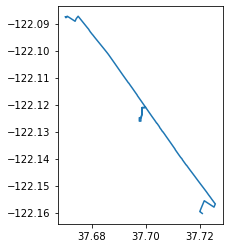

In [59]:
polyline_gdf2.plot()

### Using distance_matrix - works, but API key now restricted to `directions`

* https://traveltime.com/blog/google-distance-matrix-api-traveltime-search-api - there's 25 requests limit for `distance_matrix`

In [ ]:
#https://www.linkedin.com/pulse/calculating-distances-using-python-google-maps-r%C3%A9gis-nisengwe?articleId=6625061973447053312
'''
actual_duration = []

for i, od_tup in enumerate(zip(origin, dest)):
    result = gmaps.distance_matrix(od_tup[0], od_tup[1], mode='driving', departure_time=departures[i])["rows"][0]["elements"][0]["duration"]["value"]  
   
    result = result/3600
    actual_duration.append(result)
    
final["duration (Hours)"] = actual_duration
final
#final.to_parquet("test_od.parquet")
'''

In [ ]:
#https://faun.pub/using-google-maps-distance-matrix-api-to-create-a-distance-table-93419c409d4f

### Estimate how many requests

In [115]:
unique_routes = df[["calitp_itp_id", "route_id"]].drop_duplicates()
num_routes = len(unique_routes)

print(f"# unique routes: {num_routes}")

print(f"1st pass + 25% of stops in subset: {num_routes + 0.25*len(subset)}")
print(f"1st pass + 50% of stops in subset: {num_routes + 0.5*len(subset)}")
print(f"1st pass + 75% of stops in subset: {num_routes + 0.75*len(subset)}")
print(f"Upper bound: do not get rid of any routes, take every 3rd stop: {len(subset)}")

# unique routes: 2
1st pass + 25% of stops in subset: 6.75
1st pass + 50% of stops in subset: 11.5
1st pass + 75% of stops in subset: 16.25
Upper bound: do not get rid of any routes, take every 3rd stop: 19


In [116]:
full_df = catalog.parallel_trips_with_stops.read()

In [118]:
unique_routes = full_df[["calitp_itp_id", "route_id"]].drop_duplicates()
len(unique_routes)

2242

In [123]:
full_df[["calitp_itp_id", "route_id"]].value_counts()

calitp_itp_id  route_id  
294            22            178
               27            176
282            17305         172
314            1029          160
               1036          150
                            ... 
200            BA:Beige-S      2
               ST:82           2
               ST:4            2
482            31              1
324            8               1
Length: 2242, dtype: int64

In [127]:
ful

7860

In [ ]:
keep_trips = [-7505741281882708052]
df[df.trip_key.isin(keep_trips)]

In [ ]:
subset[subset.trip_key.isin(keep_trips)]

Don't like how `osmx` is returning the same nodes for bus stops, even at every 5th bus stop.

`osrm` doesn't install bc of some `GDAL` dependencies.

Can Google API be used? But need to check terms and conditions if we can make requests to calculate travel time or even grab speed limits through the
[Python package](https://github.com/googlemaps/google-maps-services-python)

At minimum, can calculate distance between stops, sum it up, and for cars, set an assumption of 30 mph or 45 mph. If we can't use Google API to grab speed limit, then we will hard code it.

In [ ]:
def calculate_distance_traveled(df):
    group_cols = ["calitp_itp_id", "route_id"]
    sort_cols = group_cols + ["stop_sequence"]
    
    df = df.to_crs(shared_utils.geography_utils.CA_StatePlane)
    
    # Distance traveled
    df = df.assign(
        # Previous geometry
        start = (df.sort_values(sort_cols)
                 .groupby(group_cols)["geometry"]
                 .apply(lambda x: x.shift(1))),
        end = (df.sort_values(sort_cols)
               .groupby(group_cols)["geometry"]
               .apply(lambda x: x.shift(0))
              )
    )
    
    df = df.assign(
        feet_traveled = df.end.distance(df.start) 
    ).drop(columns = ["start", "end"])
        
    return df
            

In [ ]:
df = calculate_distance_traveled(parallel)

In [ ]:
def calculate_time_traveled(df):
    # Use a set of assumptions
    
    AVG_SPEED = 40
    
    df = df.assign(
        max_stop = (df.groupby(["itp_id", "route_id", "trip_id"])
                    ["stop_sequence"].transform("max"))
    )
    
    df2 = shared_utils.geography_utils.aggregate_by_geography(
        df,
        group_cols = ["itp_id", "route_id", "trip_id", 
                     "trip_first_departure_ts", "trip_last_arrival_ts"],
        sum_cols = ["feet_traveled"], 
        mean_cols = ["service_hours", "max_stop"]
    )
    
    df2 = df2.assign(
        miles_traveled = df2.feet_traveled.divide(
            shared_utils.geography_utils.FEET_PER_MI)
    
    )
    
    # speed = distance / time
    # time = distance / speed
    df2 = df2.assign(
        car_trip_time_hr = df2.miles_traveled.divide(AVG_SPEED),
    ).drop(columns = "feet_traveled")
        
    return df2

In [ ]:
df2 = calculate_time_traveled(df)